# Navigation

---

This notebook contains my solution to the navigation challenge described in the Readme. To define and retrain the agent, execute all code cells below.

If further evaluation of the successfully trained agent is desired, this can be achieved by running the code that defines the model, skipping over the training, creating an agent and replacing its local and target network weights with weights loaded from the checkpoint file (code for this is not included).

### 1. Set up the Environment

Install dependencies by running the following cell.

In [1]:
!pip -q install ./python

Connect to the Unity Environment that defines the environment for our learning task. If running this notebook on the Jupyter environment of the Udacity course, execute the following cell as is - the environment is preinstalled in this case. If running locally, you may need to edit the `file_name` to match your installation location and the operating system dependent filename.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below if running in the Udacity environment
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

Let us examine the state and action spaces provided by the environment to check that we have understood the environment description correctly and are ready to define an agent that makes use of the available observations and actions.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


We can see that there are four available actions as expected, and that states have a length of 37, also as expected based on documentation. It is not at all obvious what the structure of the observation vector is, but perhaps an agent can learn to make use of it through reinforcement learning even if its programmer does not understand the observation.

### 3. Define an artificial neural network that can be used as a Q estimator in this environment, and a replay buffer for reusing past experience.

Import libraries.

In [5]:
from collections import namedtuple, deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We define a neural network with 2 hidden layers to represent our estimates for the Q values of the optimal policy.

The network is set up so that given a state/observation, it will simultaneusly output the Q value estimates of each action. Because of this, the output layer size needs to match the number of available actions in the environment.

Similarly the size of the input to the network should match the size of the observed state (after preprocessing if any).

The sizes of the hidden layers can also be given as parameters. I have chosen [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) as the nonlinearity after each hidden layer. There is no nonlinearity after the final fully connected layer as the ability to represent arbitrary Q-values is desirable.

In [6]:
class QNetwork3Layer(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, nh1=64, nh2=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork3Layer, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.FC1 = nn.Linear(state_size, nh1)
        self.FC2 = nn.Linear(nh1, nh2)
        self.Output = nn.Linear(nh2, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        return self.Output(F.relu(self.FC2(F.relu(self.FC1(state)))))


In order to employ the Deep Q-Learning algorithm, we will need a replay buffer for tracking past experience.

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 4. Agent definition

Equipped with a neural network that could potentially learn to estimate Q-values and a replay buffer to help us re-use experience in the Deep Q-Learning algorithm, we are ready to define an agent that combines these to explore and learn to behave more effectively in the given environment.

The agent maintains a replay buffer for past training samples, and two Q-Networks. When learning, the weights of the `local` network are optimized, using `target` network together with rewards to set the target for learning. Weights of the target network are updated to follow the local weights slowly.

For updating the local weights, Adam optimizer is used.

In [8]:
# Depending on whether Cuda is available, place tensor computations on the GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed,
                 buffer_size=int(1e5),
                 batch_size=64,
                 gamma=0.99,
                 tau=1e-3,
                 lr=5e-4,
                 update_every=1,
                 batches_per_update=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            buffer_size (int): how many steps of past experience to retain
            batch_size (int): how many samples from experience to use in one minibatch of training
            gamma: discount rate for rewards
            tau: the rate at which weights are transferred from the currently optimized Q-network to the target network
            lr: learning rate
            update_every: update network weights after this many timesteps
            batches_per_update: how many weight updates to carry out each time training occurs (how many minibatches and
              transfers of weights from current to target network)
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.batches_per_update = batches_per_update

        # Q-Network
        self.qnetwork_local = QNetwork3Layer(self.state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork3Layer(self.state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Keep track of experience, and learn."""
        # Save experience in replay buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                # Carry out batches_per_update updates.
                for i in range(0, self.batches_per_update):
                    experiences = self.memory.sample()
                    self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        # Epsilon-greedy action selection
        if random.random() > eps:
            with torch.no_grad():
                action_values = self.qnetwork_local(state)
                return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        # set networks to training mode in case any layers have mode dependent behaviour.
        self.qnetwork_local.train()
        self.qnetwork_target.train()
        with torch.no_grad():
            next_qs = self.qnetwork_target.forward(next_states)
            max_next_qs = next_qs.max(1, keepdim=True)[0]
            targets = (1 - dones) * self.gamma * max_next_qs + rewards
        self.optimizer.zero_grad()
        prediction = self.qnetwork_local.forward(states).gather(1, actions)
        loss = F.mse_loss(prediction, targets)
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target)                     

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)


### 5. Train the agent with deep Q-learning

Define a function to carry out the [deep Q-learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) algorithm.

Because the ray-based observation might miss bananas that fall between rays when the agent turns, we include preprocessing which concatenates the four most recent observations and presents the agent with this combined vector as the state / observation vector.

In [9]:
def dqn(agent, max_episode=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, previous_scores = None):
    """Deep Q-Learning.
    
    Params
    ======
        agent (Agent): the agent to train
        max_episodes (int): maximum number of training episodes, including any episodes supplied in previous_scores
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        previous_scores (array of float): scores from earlier training phases.
    """
    scores = previous_scores if previous_scores else []           # list containing scores from each episode
    scores_window = deque(scores, maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(len(scores) + 1, max_episode+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state_frame = env_info.vector_observations[0]            # get the current state
        # we want to preprocess the state to concatenate 4 most recent observations.
        # Initialise with 4 times the initial observation.
        state = np.hstack([state_frame, state_frame, state_frame, state_frame])
        score = 0
        for t in range(0, max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state_frame = env_info.vector_observations[0]   # get the next state
            next_state = np.hstack([state[1:-state_size + 1], next_state_frame]) # concatenate four most recent states
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

Perform a grid search over a few different parameter choices to understand which hyperparameters look promising.

In [10]:
params = namedtuple("Params", field_names=["lr", "tau", "frames_between_update"])


In [11]:
params_grid = [params(lr, tau, frames_between_update)
               for lr in [1e-3, 3e-4, 1e-4]
               for tau in [1e-3, 1e-4]
               for frames_between_update in [1, 4]]
params_grid

[Params(lr=0.001, tau=0.001, frames_between_update=1),
 Params(lr=0.001, tau=0.001, frames_between_update=4),
 Params(lr=0.001, tau=0.0001, frames_between_update=1),
 Params(lr=0.001, tau=0.0001, frames_between_update=4),
 Params(lr=0.0003, tau=0.001, frames_between_update=1),
 Params(lr=0.0003, tau=0.001, frames_between_update=4),
 Params(lr=0.0003, tau=0.0001, frames_between_update=1),
 Params(lr=0.0003, tau=0.0001, frames_between_update=4),
 Params(lr=0.0001, tau=0.001, frames_between_update=1),
 Params(lr=0.0001, tau=0.001, frames_between_update=4),
 Params(lr=0.0001, tau=0.0001, frames_between_update=1),
 Params(lr=0.0001, tau=0.0001, frames_between_update=4)]

Run a limited length training procedure at each hyperparameter combination defined above. Use starting epsilon of 0.5. In initial testing it appeared that very high epsilon values did not allow any learning to happen, presumably because the agent was not moving forward enough to encounter bananas at all in most test runs.

We use the default hidden layer sizes as defined by the neural network definition above. This means 64 hidden units in each of the hidden layers.

In [12]:
agents = [Agent(state_size=state_size * 4, action_size=action_size, seed=4, lr=p.lr, tau=p.tau, update_every=p.frames_between_update)
          for p in params_grid]

In [13]:
scores = [dqn(agent, eps_start = 0.5, eps_end = 0.05, eps_decay = 0.997, max_episode=200) for agent in agents]


Episode 100	Average Score: 0.37
Episode 200	Average Score: 0.95
Episode 100	Average Score: 1.71
Episode 200	Average Score: 4.29
Episode 100	Average Score: 1.38
Episode 200	Average Score: 3.05
Episode 100	Average Score: 0.08
Episode 200	Average Score: 1.16
Episode 100	Average Score: 1.73
Episode 200	Average Score: 4.18
Episode 100	Average Score: 2.05
Episode 200	Average Score: 5.58
Episode 100	Average Score: 0.62
Episode 200	Average Score: 2.24
Episode 100	Average Score: 0.55
Episode 200	Average Score: 0.67
Episode 100	Average Score: 2.19
Episode 200	Average Score: 6.41
Episode 100	Average Score: -0.01
Episode 200	Average Score: 1.28
Episode 100	Average Score: 0.82
Episode 200	Average Score: 2.68
Episode 100	Average Score: 0.56
Episode 200	Average Score: 0.96


It appears the 9th agent performs best in this trial. Let us continue training this one with epsilon continuing from where it would be left after the 200 episodes above.

In [15]:
best_agent = agents[8]
cont_scores = dqn(best_agent, eps_start = 0.275, eps_end = 0.1, eps_decay = 0.997, max_episode=5000, previous_scores = scores[8])


Episode 300	Average Score: 7.65
Episode 400	Average Score: 8.42
Episode 500	Average Score: 10.15
Episode 600	Average Score: 10.86
Episode 700	Average Score: 10.93
Episode 800	Average Score: 11.08
Episode 900	Average Score: 11.33
Episode 1000	Average Score: 11.33
Episode 1100	Average Score: 11.12
Episode 1200	Average Score: 10.86
Episode 1300	Average Score: 11.59
Episode 1400	Average Score: 11.97
Episode 1500	Average Score: 11.76
Episode 1600	Average Score: 11.32
Episode 1700	Average Score: 12.32
Episode 1800	Average Score: 12.35
Episode 1900	Average Score: 11.81
Episode 2000	Average Score: 12.08
Episode 2100	Average Score: 11.88
Episode 2200	Average Score: 11.11
Episode 2300	Average Score: 11.69
Episode 2400	Average Score: 12.47
Episode 2500	Average Score: 12.90
Episode 2504	Average Score: 13.00
Environment solved in 2404 episodes!	Average Score: 13.00


### 6. Results

As we can see in the output above, the agent trained with the hyperparameters that seemed most promising solved the invironment in 2404 steps when we continued the training. The model weights at the end of the evaluation have now been saved in the file `checkpoint.pth` and can be loaded from there if any later evaluation is desired. Finally, let us plot the scores to see how the agent improved its performance over the training episodes.

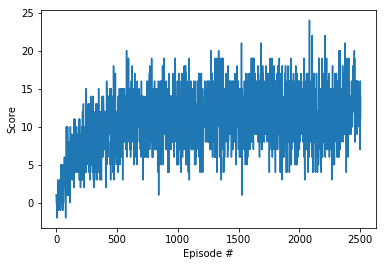

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(cont_scores)), cont_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The plot shows that learning does not proceed very effectively in this case after reaching an average return of approximately 10 per episode in 500 episodes.

To finish off, we can close the Unity environment.

In [19]:
env.close()

### 7. Further work

The most obvious short term avenue for further work would be to investigate why learning slowed down around average return levels of 10 to 11, after 500 episodes. Running multiple training runs or trying different hyperparameters at this stage of the training could shed light into reasons of slow learning.

Additionally, further work could proceed in at least three broad directions: Optimizing the agent's structure, using a more sophisticated learning algorithm, or solving the environment based on pixel input instead of the ray-based observations used in this version.

#### Optimizing the agent structure

It would be interesting to see whether quicker learning results can be achieved with a different neural network architecture or preprocessing. For example, a more powerful neural network could be created by adding another hidden layer. As the neural network becomes more expressive, the risk of overfitting to observations increases. This could be countered e.g. by including dropout regularisation in the network. Equally, it would be interesting to see if adequate results can be achieved with an even smaller neural network and less preprocessing.

#### More sophisticated learning algorithm

The simple DQN algorithm could be improved by implementing:
 - [Double Q Learning](https://papers.nips.cc/paper/3964-double-q-learning), reducing the tendency for a SARSAMAX (like Deep Q-learning) algorithm to overestimate Q values.
 - [Dueling Networks](https://arxiv.org/abs/1511.06581) where instead of the action value function Q, a network with two "heads" estimates the state value function V and the action depended advantage function A separately, resulting in lower variance
 - [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952) which makes better use of recorded experience by focusing on samples that the network has trouble estimating correctly.

#### Pixel based version of the environment

A version of the environment with pixel based first person view is available. Solving this would require a larger neural network, but potentially allow for better solutions due to more information available for the agent.